In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from ripser import Rips
from tadasets import torus, sphere
from persim.landscapes import PersLandscapeExact
from persim.landscapes import plot_landscape_simple
from persim.landscapes import PersistenceLandscaper
from persim import plot_diagrams

from sklearn.decomposition import PCA
from sklearn import svm
from sklearn import metrics
from sklearn.model_selection import train_test_split

## Datasets

In [2]:
data_torus = torus(n=100, c=2, a=1)
data_sphere = sphere(n=100, r=2)

## Compute Vietoris-Rips persistence diagrams

In [3]:
rips = Rips(maxdim = 2)

dgms_torus = rips.fit_transform(data_torus)
dgms_sphere = rips.fit_transform(data_sphere)

Rips(maxdim=2, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)


### Plot persistence diagrams

In [4]:
# fig, axs = plt.subplots(1, 2, dpi=300)
# fig.set_size_inches(10, 5)

# plot_diagrams(dgms_torus, title="Persistence Diagram of Torus", ax=axs[0])

# plot_diagrams(dgms_sphere, title="Persistence Diagram of Sphere", ax=axs[1])

# fig.tight_layout()

<AxesSubplot: >

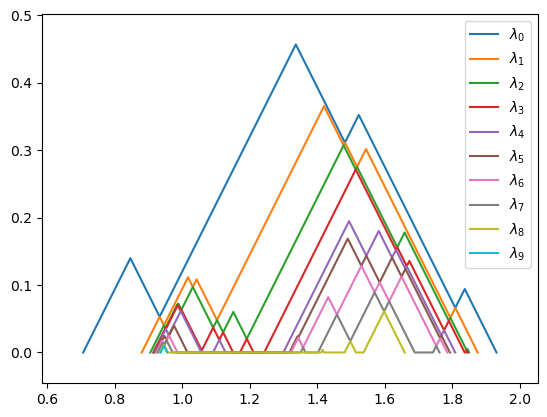

In [8]:
ple = PersLandscapeExact(dgms = dgms_torus, hom_deg=1)

plt.rcParams['text.usetex'] = False
plot_landscape_simple(ple)

### Total lambda data

In [7]:
len(ple.critical_pairs)

10

### First lambda data

In [9]:
print(ple.critical_pairs[0])

[[0.7066895365715027, 0], [0.8464424014091492, 0.13975286483764648], [0.9331886768341064, 0.05300658941268921], [1.3366198241710663, 0.45643773674964905], [1.482086956501007, 0.31097060441970825], [1.5231585502624512, 0.35204219818115234], [1.809049367904663, 0.06615138053894043], [1.837023138999939, 0.09412515163421631], [1.9311482906341553, 0]]


### lens of each lambda

In [10]:
total_data = [len(i) for i in ple.critical_pairs]
total_data

[9, 15, 23, 26, 21, 25, 20, 20, 14, 3]

In [11]:
landscapes_torus = []
landscapes_sphere = []

for i in range(20):
    # Resample data
    _data_torus = torus(n=100, c=2, a=1)
    _data_sphere = sphere(n=100, r=2)

    # persistence diagrams
    dgm_torus = rips.fit_transform(_data_torus)
    dgm_sphere = rips.fit_transform(_data_sphere)

    # persistence landscape transformer
    torus_landscaper = PersistenceLandscaper(hom_deg=1, start=0, stop=2.0, num_steps=500, flatten=True)
    sphere_landscaper = PersistenceLandscaper(hom_deg=1, start=0, stop=2.0, num_steps=500, flatten=True)

    # flattened persistence landscape
    torus_flat = torus_landscaper.fit_transform(dgm_torus)
    sphere_flat = sphere_landscaper.fit_transform(dgm_sphere)
    
    landscapes_torus.append(torus_flat)
    landscapes_sphere.append(sphere_flat)

landscapes_torus = np.array(landscapes_torus, dtype=object)
landscapes_sphere = np.array(landscapes_sphere, dtype=object)

print('Torus:', np.shape(landscapes_torus))
print('Sphere:', np.shape(landscapes_sphere))

Torus: (20,)
Sphere: (20,)


In [12]:
[len(i) for i in landscapes_torus]

[7000,
 6000,
 7000,
 6000,
 4500,
 5500,
 5500,
 6500,
 5500,
 5500,
 6500,
 6500,
 4500,
 5500,
 5000,
 5000,
 6000,
 6000,
 6000,
 5000]

# Populate arrays

In [13]:
u = np.max([len(a) for a in landscapes_torus])
v = np.max([len(a) for a in landscapes_sphere])

w = np.max([u,v])

ls_torus = np.zeros((100, w))
ls_sphere = np.zeros((100, w))

for i in range(len(landscapes_torus)):
    ls_torus[i, 0:len(landscapes_torus[i])] = landscapes_torus[i]
    ls_sphere[i, 0:len(landscapes_sphere[i])] = landscapes_sphere[i]


print('Torus:', ls_torus.shape)
print('Sphere:', ls_sphere.shape)

Torus: (100, 7000)
Sphere: (100, 7000)


## PCA

In [40]:
pca_torus = PCA(n_components=2)
pca_sphere = PCA(n_components=2)

pca_torus.fit_transform(ls_torus)
pca_sphere.fit_transform(ls_sphere)

comp_torus = pca_torus.components_
comp_sphere = pca_sphere.components_

In [15]:
[len(i) for i in  comp_torus]

[7000, 7000]

## Plot projection of data onto the first two principal components

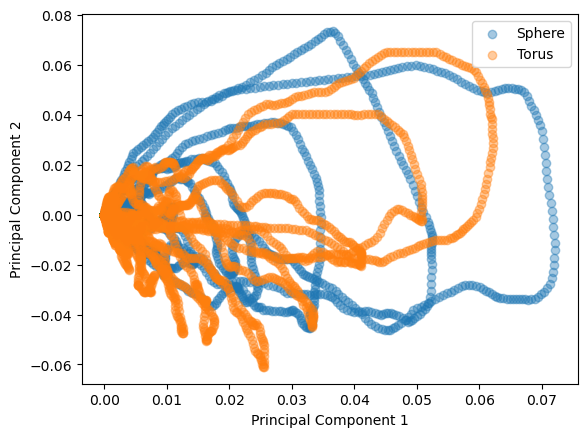

In [16]:
plt.figure()
plt.scatter(comp_sphere[0], comp_sphere[1], label='Sphere', alpha=0.4)
plt.scatter(comp_torus[0], comp_torus[1], label='Torus', alpha=0.4)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()

1. chi: label
2. pts:data

In [17]:
# Produce lists of points
pts_torus = [[comp_torus[0,i], comp_torus[1,i]] for i in range(len(comp_torus[0]))]
pts_sphere = [[comp_sphere[0,i], comp_sphere[1,i]] for i in range(len(comp_sphere[0]))]

# Indicator functions
chi_torus = np.zeros(len(pts_torus))
chi_sphere = np.ones(len(pts_sphere))

# Produce final list of points
pts = []

for p in pts_torus:
    pts.append(p)
for p in pts_sphere:
    pts.append(p)

pts = np.array(pts)

# Indicator functions
chi = np.hstack((chi_torus, chi_sphere))

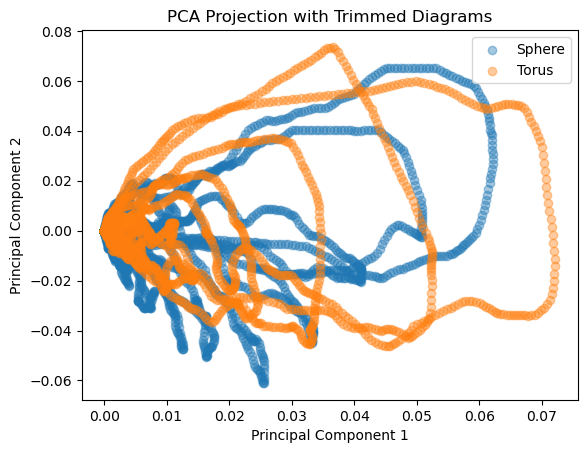

In [35]:
plt.figure()
plt.scatter(comp_torus[0], comp_torus[1], label='Sphere', alpha=0.4)
plt.scatter(comp_sphere[0], comp_sphere[1], label='Torus', alpha=0.4)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Projection with Trimmed Diagrams')
plt.legend()

## Split points for SVC

In [18]:
P_train, P_test, c_train, c_test = train_test_split(pts, chi, train_size=.8)

clf = svm.SVC()
clf.fit(P_train, c_train)

print(f'Model accuracy: {metrics.accuracy_score(c_test, clf.predict(P_test)):.2f}')

Model accuracy: 0.58


# Improve accuracy

## 1. Delete highly persistent landscapes

In [41]:
# Delete highly persistent landscapes

# Instantiate trimmed arrays
ls_torus_trim = ls_torus
ls_sphere_trim = ls_sphere

# Trim arrays
for i in range(len(landscapes_torus)):
    ls_torus_trim[i, 0:1000] = np.zeros((1000,))
    ls_sphere_trim[i, 0:1000] = np.zeros((1000,))


print('Torus:', ls_torus_trim.shape)
print('Sphere:', ls_sphere_trim.shape)

Torus: (100, 7000)
Sphere: (100, 7000)


In [29]:
# Instantiate PCA solver
pca_torus_trim = PCA(n_components=2)
pca_sphere_trim = PCA(n_components=2)

# Compute PCA
pca_torus_trim.fit_transform(ls_torus_trim)
pca_sphere_trim.fit_transform(ls_sphere_trim)

# Define components
comp_torus_trim = pca_torus_trim.components_
comp_sphere_trim = pca_sphere_trim.components_

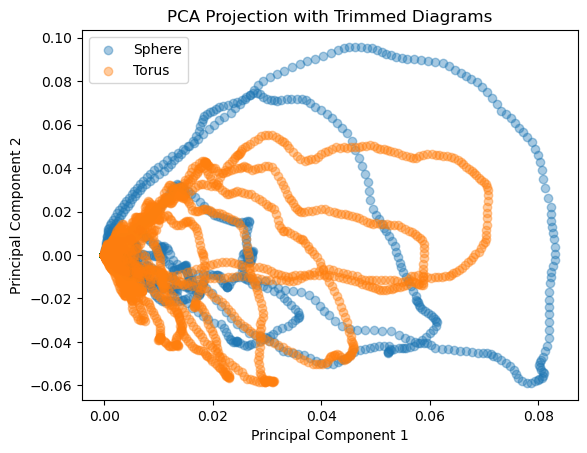

In [30]:
# Plot projection of data onto the first two principal components
plt.figure()
plt.scatter(comp_sphere_trim[0], comp_sphere_trim[1], label='Sphere', alpha=0.4)
plt.scatter(comp_torus_trim[0], comp_torus_trim[1], label='Torus', alpha=0.4)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Projection with Trimmed Diagrams')
plt.legend()

In [32]:
# Produce lists of points
pts_torus_trim = [[comp_torus_trim[0,i], comp_torus_trim[1,i]] for i in range(len(comp_torus_trim[0]))]
pts_sphere_trim = [[comp_sphere_trim[0,i], comp_sphere_trim[1,i]] for i in range(len(comp_sphere_trim[0]))]

# Instantiate indicator functions
chi_torus_trim = np.zeros(len(pts_torus_trim))
chi_sphere_trim = np.ones(len(pts_sphere_trim))

# Produce final list of points
pts_trim = []

for p in pts_torus_trim:
    pts_trim.append(p)

for p in pts_sphere_trim:
    pts_trim.append(p)

pts_trim = np.array(pts_trim)

# Append indicator functions
chi_trim = np.hstack((chi_torus_trim, chi_sphere_trim))

In [33]:
P_train_trim, P_test_trim, c_train_trim, c_test_trim = train_test_split(pts_trim, chi_trim, train_size=.8)

clf_trim = svm.SVC()
clf_trim.fit(P_train_trim, c_train_trim)

print(f'Model accuracy: {metrics.accuracy_score(c_test_trim, clf_trim.predict(P_test_trim)):.2f}')

Model accuracy: 0.58


## 2. multicomponent

In [42]:
# Instantiate multicomponent PCA solver
pca_torus_mcomp = PCA(n_components=6)
pca_sphere_mcomp = PCA(n_components=6)

# Compute PCA
pca_torus_mcomp.fit_transform(ls_torus)
pca_sphere_mcomp.fit_transform(ls_sphere)

# Define components
comp_torus_mcomp = pca_torus_mcomp.components_
comp_sphere_mcomp = pca_sphere_mcomp.components_

In [43]:
# Produce lists of points
pts_torus_mcomp = [[comp_torus_mcomp[j,i] for j in range(6)] for i in range(len(comp_torus_mcomp[0]))]
pts_sphere_mcomp = [[comp_sphere_mcomp[j,i] for j in range(6)] for i in range(len(comp_sphere_mcomp[0]))]

# Instantiate indicator functions
chi_torus_mcomp = np.zeros(len(pts_torus_mcomp))
chi_sphere_mcomp = np.ones(len(pts_sphere_mcomp))

# Produce final list of points
pts_mcomp = []

for p in pts_torus_mcomp:
    pts_mcomp.append(p)

for p in pts_sphere_mcomp:
    pts_mcomp.append(p)

pts_mcomp = np.array(pts_mcomp)

# Append indicator functions
chi_mcomp = np.hstack((chi_torus_mcomp, chi_sphere_mcomp))

In [46]:
pts.shape

(14000, 2)

In [47]:
P_train_mcomp, P_test_mcomp, c_train_mcomp, c_test_mcomp = train_test_split(pts_mcomp, chi_mcomp, train_size=.8)

clf_mcomp = svm.SVC()
clf_mcomp.fit(P_train_mcomp, c_train_mcomp)

print(f'Model accuracy: {metrics.accuracy_score(c_test_mcomp, clf_mcomp.predict(P_test_mcomp)):.2f}')

Model accuracy: 0.61


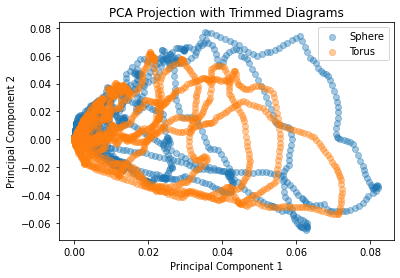

In [40]:
plt.figure()
plt.scatter(comp_sphere_mcomp[0], comp_sphere_mcomp[1], label='Sphere', alpha=0.4)
plt.scatter(comp_torus_mcomp[0], comp_torus_mcomp[1], label='Torus', alpha=0.4)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Projection with Trimmed Diagrams')
plt.legend()